In [2]:
# Konfiguracja startowa
import pickle

DO_TRAIN = False  # czy trenowanie ma być wykonane na nowo, czy wczytane z dysku (jak z dysku to też zbiór testowy jest z dysku, augmentacja itd.)

def load_cache(fn):
    with open(fn, 'rb') as cf:
        return pickle.load(cf)


def write_cache(fn, data):
    with open(fn, 'wb') as cf:
        pickle.dump(data, cf)

In [3]:
# Załadowanie hitów w PNG z katalogu hit-images-final2
# z podziałem na "dot", "track" i "worm" (podkatalogi)

from align_images_pca import align_image
from PIL import Image
import numpy as np
import glob


CACHE_IMAGES = 'cache/images_v2.pickle'

ALL_SRC = 'wybrane_final'


def load_images(src):
    images = []
    files_used = []
    files = list(glob.glob("%s/*.png" % src))
    files = sorted(files)
    for image_path in files:
        img = Image.open(image_path)
        img = img.convert('L')
        image = np.asarray(img)
        #image = np.asarray(Image.open(image_path).convert('L'))
        image = align_image(image)
        mask = np.where(image > 25, 1, 0)
        image = mask * image
        if np.max(image) == 0:
            continue
        image = image.astype(np.float32) / np.max(image)
        image = np.expand_dims(image, 2)
        images.append(image)
        files_used.append(image_path)
    return np.asarray(images), files_used


if DO_TRAIN:
    all_set, all_files = load_images(ALL_SRC)
    write_cache(CACHE_IMAGES, [all_set, all_files])
else:
    [all_set, all_files] = load_cache(CACHE_IMAGES)

print('len(all_set): %d' % all_set.shape[0])

len(all_set): 13824


In [4]:
# augmentacja przez mirror, czyli pomnożenie próbek 2x przez dodanie lustrzanie odbitych

import pickle
CACHE_AUGMENTATION = 'cache/augmentation_v2.pickle'

def augmentation_mirror(src, files):
    images = []
    files_aug = []
    for i in range(0, len(src)):
        img = src[i]
        images.append(img)
        images.append(np.flip(img))
        files_aug.append(files[i])
        files_aug.append(files[i])
    return np.asarray(images), files_aug

if DO_TRAIN:
    all2_set, all2_files = augmentation_mirror(all_set, all_files)
    write_cache(CACHE_AUGMENTATION, [all2_set, all2_files])
else:
    [all2_set, all2_files] = load_cache(CACHE_AUGMENTATION)

print('len(dots2_set): %d' % all2_set.shape[0])

len(dots2_set): 27648


In [5]:
# wygenerowanie zbioru train, validate i test o proporcjach odpowiednio 60%, 20% i 20%
# zwracane listy zawierają indeksy próbek, które zostały przydzielone do ww. ziorów

import pickle
CACHE_DIV = 'cache/sets_tvt.pickle'

def train_validate_test_split(df, train_percent=.8, seed=None):
    p = np.random.permutation(df.shape[0])
    n = int(train_percent * len(p))
    train = p[:n]
    validation = p[n:]
    return train, validation

if DO_TRAIN:
    all2_train, all2_validate = train_validate_test_split(all2_set)
    write_cache(CACHE_DIV, [all2_train, all2_validate])
else:
    [all2_train, all2_validate] = load_cache(CACHE_DIV)

print('len(all2_set): %d/%d' % (all2_train.shape[0], all2_validate.shape[0]))

len(all2_set): 22118/5530


In [6]:
# wytrenowanie kanałów
# * tracks
# * tnd (tracks and dots)

from commons import *
from dataset_loader import load_from_file
from IPython.display import display
import matplotlib.pyplot as plt
import cv2

#DOTS_DST = 'cache/dots_100000.pickle'
#ARTIFACTS_DST = 'cache/artifacts_100000.pickle'

#DOTS_AC = 'cache/dots_100000.h5'
#TRACKS_AC = 'cache/th_dots_optics_100000.h5'
#WORMS_AC = 'cache/worms_100000.h5'
#ARTIFACTS_AC = 'cache/artifacts_100000.h5'
ALL_AC = 'cache/th_all_%d.h5'

def train_and_test(train_set, validation_set, fn_template, latentDim=16):
    fn = fn_template % latentDim
    autoencoder = original_autoencoder(latentDim=latentDim)
    autoencoder = train_or_cache(train_set, autoencoder, fn, validation_set=validation_set, force_train=True, latentDim=latentDim)

    for df_func, df_name in zip(
            [dm_func_mean],
            ['mean']
    ):
        for img_set, set_names in zip([validation_set], ['train']):
            decoded = autoencoder.predict(img_set)

            vis, errors = visualize_predictions(decoded, img_set, df_func, False, 16)
            img_path = fn.replace('.h5', '-vis.png')
            hist_path = fn.replace('.h5', '-hist.png')
            cv2.imwrite(img_path, vis)
            display(Image.open(img_path))
            if len(img_set) > 256:
                vis, errors = visualize_predictions(decoded, img_set, df_func, False)
                img_path = fn.replace('.h5', '-vis_full.png')
                cv2.imwrite(img_path, vis)

            plt.figure(figsize=(8,6))
            plt.hist(errors, bins=100, alpha=0.5, label=set_names)
            plt.xlabel("Data", size=14)
            plt.ylabel("Count", size=14)
            plt.title(df_name)
            plt.legend(loc='upper right')
            plt.savefig(hist_path)

if DO_TRAIN:
    for latentD in [16]:
        train_and_test(all2_set[all2_train], all2_set[all2_validate], ALL_AC, latentD)

In [7]:
if DO_TRAIN:
    for latentD in [2, 4, 6, 8, 12, 24, 32, 48, 64]:
        train_and_test(all2_set[all2_train], all2_set[all2_validate], ALL_AC, latentD)

In [8]:
# zapis embeddingu do pliku

from keras.models import load_model

def encoder_embedding(model_file, test_set):
    encoder = load_model(model_file.replace('.h5', '-encoder.h5'))
    embedding = encoder.predict(test_set)
    #with_c = np.vstack([v, np.ones(v.shape) * c])
    #transposed = with_c.transpose()
    return embedding

#all_embedding = encoder_embedding(ALL_AC % 64, all_set)
#all_embedding_files = np.hstack(all_files)


# np.save("res/emb_array_all_%d" % 16, all_embedding)

# with open("res/file_list_all.txt", 'w') as fp:
#     for ff in all_embedding_files:
#         fp.write(ff + "\n")


In [9]:
zero_to_one = (np.asarray(range(10)) + 1) / 10.0
one_to_ten = np.asarray(range(9)) + 2
ten_to_hundreds = (np.asarray(range(39)) + 2) * 10

eps_used = list((np.hstack([zero_to_one, one_to_ten, ten_to_hundreds])))
print(eps_used)

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0, 110.0, 120.0, 130.0, 140.0, 150.0, 160.0, 170.0, 180.0, 190.0, 200.0, 210.0, 220.0, 230.0, 240.0, 250.0, 260.0, 270.0, 280.0, 290.0, 300.0, 310.0, 320.0, 330.0, 340.0, 350.0, 360.0, 370.0, 380.0, 390.0, 400.0]


In [10]:
def find_sigma(func, embedding, t_files, latentDim, min_samples=5, start_eps=200, percent=0.2):
    size = float(embedding.shape[0])
    left_eps = 0.1
    right_eps = 1000.0
    looking_count = round(size * (percent / 100.0))
    while True:
        eps = (left_eps + right_eps) / 2.0
        p = func(embedding, t_files, latentDim, eps, False, min_samples)
        if p == looking_count:
            break

        if p > looking_count:
            left_eps = eps
        else:
            right_eps = eps
    print('Znalezione: latentDim=%d, min_samples=%d, eps=%f' % (latentDim, min_samples, eps))
    func(embedding, t_files, latentDim, eps, True, min_samples)
    return eps


looking_ld = [2, 4, 6, 8, 12, 16, 24, 32, 48, 64]
looking_ms = [3, 4, 5, 6, 7, 8]

Znalezione: latentDim=2, min_samples=1, eps=7.423486
7.423486: 28
wybrane_final\13605047.png
wybrane_final\13624927.png
wybrane_final\13844465.png
wybrane_final\22008402.png
wybrane_final\22027241.png
wybrane_final\22031737.png
wybrane_final\22037785.png
wybrane_final\22053032.png
wybrane_final\22110283.png
wybrane_final\22171298.png
wybrane_final\22173151.png
wybrane_final\22204286.png
wybrane_final\22214072.png
wybrane_final\22250688.png
wybrane_final\22304957.png
wybrane_final\22324071.png
wybrane_final\22324081.png
wybrane_final\22326858.png
wybrane_final\22354720.png
wybrane_final\22398922.png
wybrane_final\22429004.png
wybrane_final\22435417.png
wybrane_final\22437067.png
wybrane_final\22484369.png
wybrane_final\22490031.png
wybrane_final\22504629.png
wybrane_final\24613229.png
wybrane_final\5392310.png


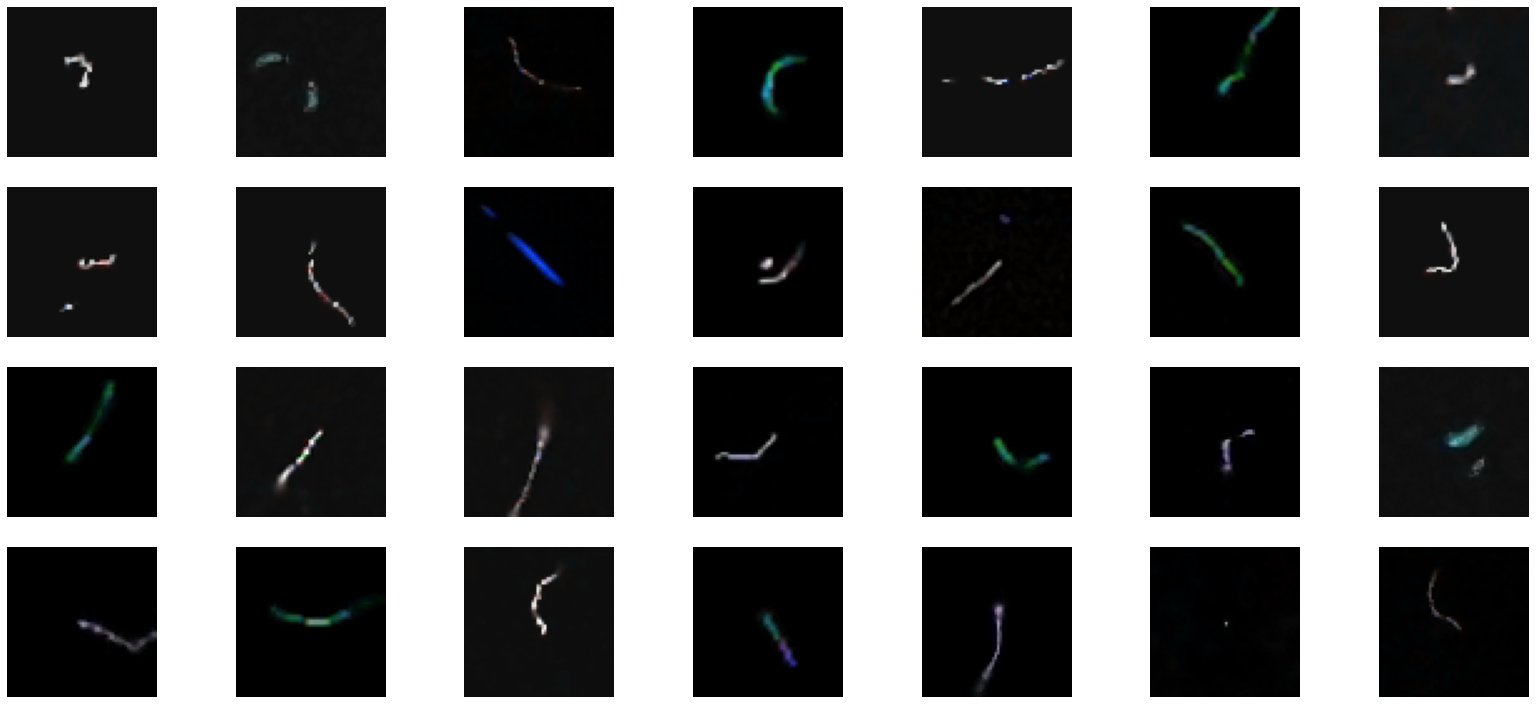

Znalezione: latentDim=4, min_samples=1, eps=130.946289
130.946289: 28
wybrane_final\11860397.png
wybrane_final\13624927.png
wybrane_final\19032702.png
wybrane_final\22010127.png
wybrane_final\22011869.png
wybrane_final\22031737.png
wybrane_final\22031935.png
wybrane_final\22114707.png
wybrane_final\22171298.png
wybrane_final\22173151.png
wybrane_final\22203839.png
wybrane_final\22231807.png
wybrane_final\22250688.png
wybrane_final\22304957.png
wybrane_final\22305630.png
wybrane_final\22307502.png
wybrane_final\22324081.png
wybrane_final\22325457.png
wybrane_final\22327042.png
wybrane_final\22353487.png
wybrane_final\22359823.png
wybrane_final\22391783.png
wybrane_final\22429004.png
wybrane_final\22497915.png
wybrane_final\22504629.png
wybrane_final\22513472.png
wybrane_final\24241803.png
wybrane_final\9279593.png


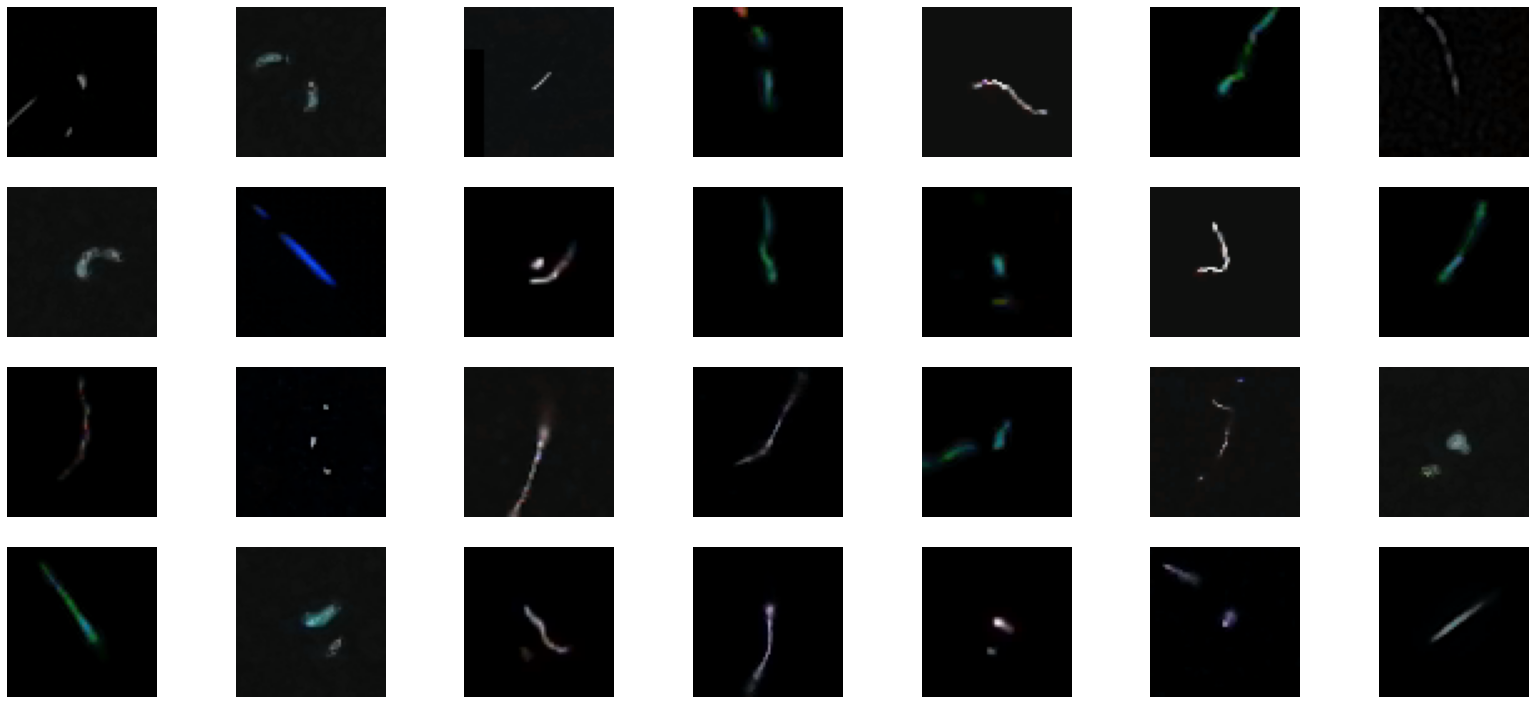

Znalezione: latentDim=6, min_samples=1, eps=186.116553
186.116553: 28
wybrane_final\11823391.png
wybrane_final\11876681.png
wybrane_final\13855513.png
wybrane_final\19032702.png
wybrane_final\22008402.png
wybrane_final\22027630.png
wybrane_final\22031737.png
wybrane_final\22036077.png
wybrane_final\22037785.png
wybrane_final\22038735.png
wybrane_final\22048276.png
wybrane_final\22171298.png
wybrane_final\22173151.png
wybrane_final\22203839.png
wybrane_final\22250688.png
wybrane_final\22305630.png
wybrane_final\22323512.png
wybrane_final\22323646.png
wybrane_final\22324081.png
wybrane_final\22327042.png
wybrane_final\22359823.png
wybrane_final\22391783.png
wybrane_final\22429004.png
wybrane_final\22437067.png
wybrane_final\22446788.png
wybrane_final\22490954.png
wybrane_final\24306517.png
wybrane_final\5222229.png


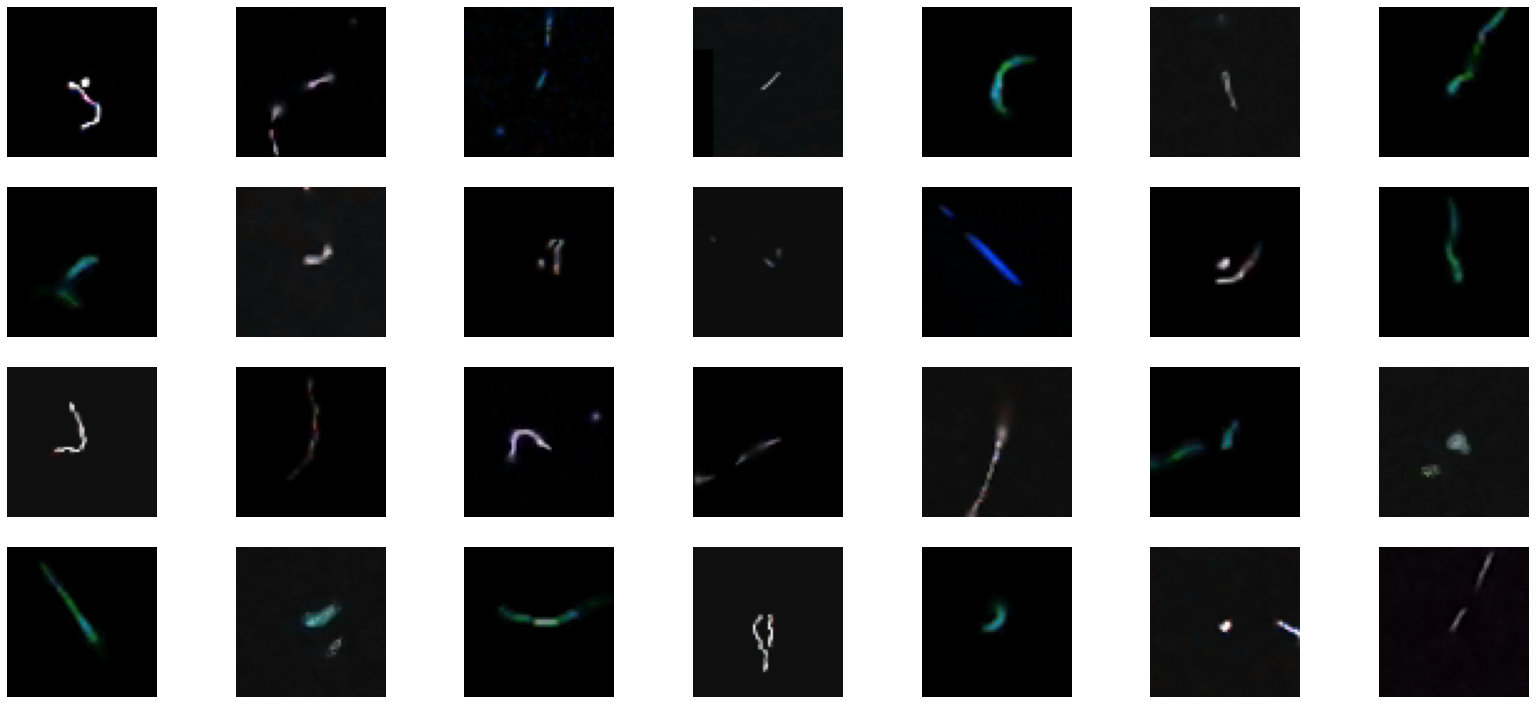

Znalezione: latentDim=8, min_samples=1, eps=267.651367
267.651367: 28
wybrane_final\11823391.png
wybrane_final\11860397.png
wybrane_final\11860402.png
wybrane_final\11876681.png
wybrane_final\13624927.png
wybrane_final\22011869.png
wybrane_final\22027241.png
wybrane_final\22031737.png
wybrane_final\22037785.png
wybrane_final\22110706.png
wybrane_final\22111155.png
wybrane_final\22114707.png
wybrane_final\22180015.png
wybrane_final\22180819.png
wybrane_final\22182800.png
wybrane_final\22203839.png
wybrane_final\22215672.png
wybrane_final\22250688.png
wybrane_final\22323512.png
wybrane_final\22327042.png
wybrane_final\22339980.png
wybrane_final\22347601.png
wybrane_final\22359823.png
wybrane_final\22393613.png
wybrane_final\22429004.png
wybrane_final\22437067.png
wybrane_final\22499941.png
wybrane_final\22515439.png


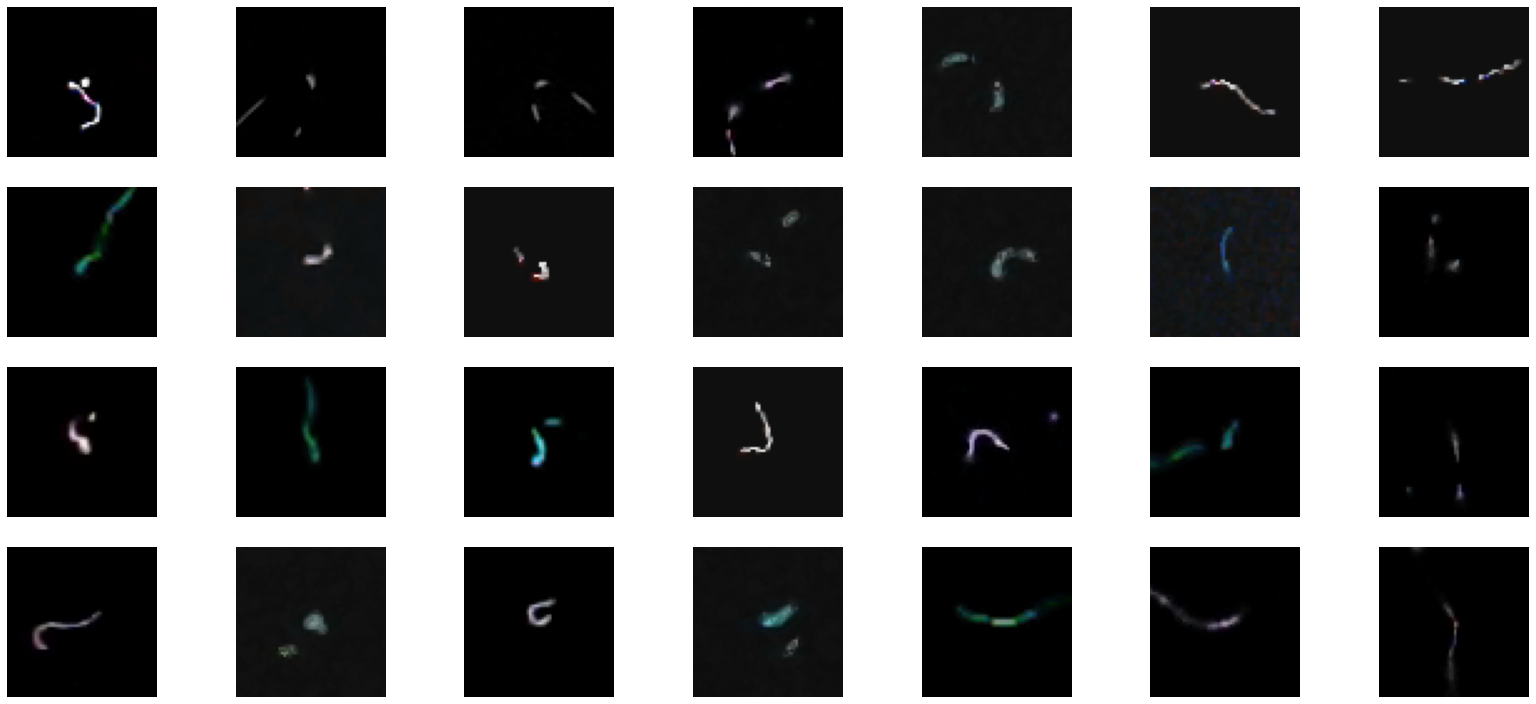

Znalezione: latentDim=12, min_samples=1, eps=330.145117
330.145117: 28
wybrane_final\11636367.png
wybrane_final\11665291.png
wybrane_final\11876681.png
wybrane_final\1208155.png
wybrane_final\13843278.png
wybrane_final\13855513.png
wybrane_final\19032702.png
wybrane_final\22031737.png
wybrane_final\22038735.png
wybrane_final\22053032.png
wybrane_final\22114707.png
wybrane_final\22174470.png
wybrane_final\22180015.png
wybrane_final\22180819.png
wybrane_final\22182800.png
wybrane_final\22215672.png
wybrane_final\22250688.png
wybrane_final\22266498.png
wybrane_final\22283045.png
wybrane_final\22323512.png
wybrane_final\22343774.png
wybrane_final\22347601.png
wybrane_final\22353487.png
wybrane_final\22359823.png
wybrane_final\22429004.png
wybrane_final\22446788.png
wybrane_final\23321006.png
wybrane_final\4423996.png


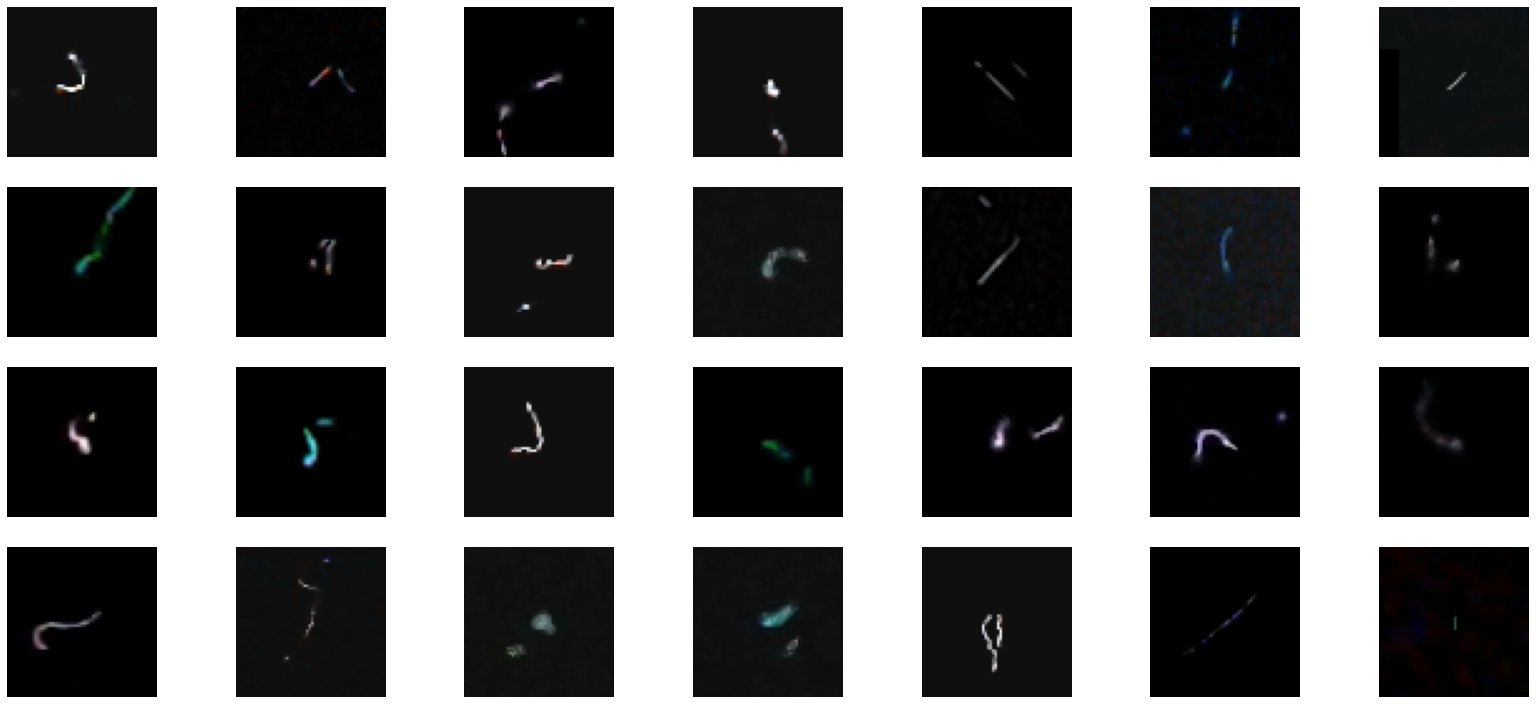

Znalezione: latentDim=16, min_samples=1, eps=375.062500
375.062500: 28
wybrane_final\11078627.png
wybrane_final\11636367.png
wybrane_final\11823391.png
wybrane_final\11860402.png
wybrane_final\11876681.png
wybrane_final\13624927.png
wybrane_final\13831135.png
wybrane_final\13843278.png
wybrane_final\16200790.png
wybrane_final\22027955.png
wybrane_final\22031737.png
wybrane_final\22031935.png
wybrane_final\22038735.png
wybrane_final\22053032.png
wybrane_final\22111155.png
wybrane_final\22174470.png
wybrane_final\22180015.png
wybrane_final\22180819.png
wybrane_final\22215672.png
wybrane_final\22250688.png
wybrane_final\22323512.png
wybrane_final\22343771.png
wybrane_final\22359823.png
wybrane_final\22425702.png
wybrane_final\22429004.png
wybrane_final\22432354.png
wybrane_final\22437786.png
wybrane_final\22772316.png


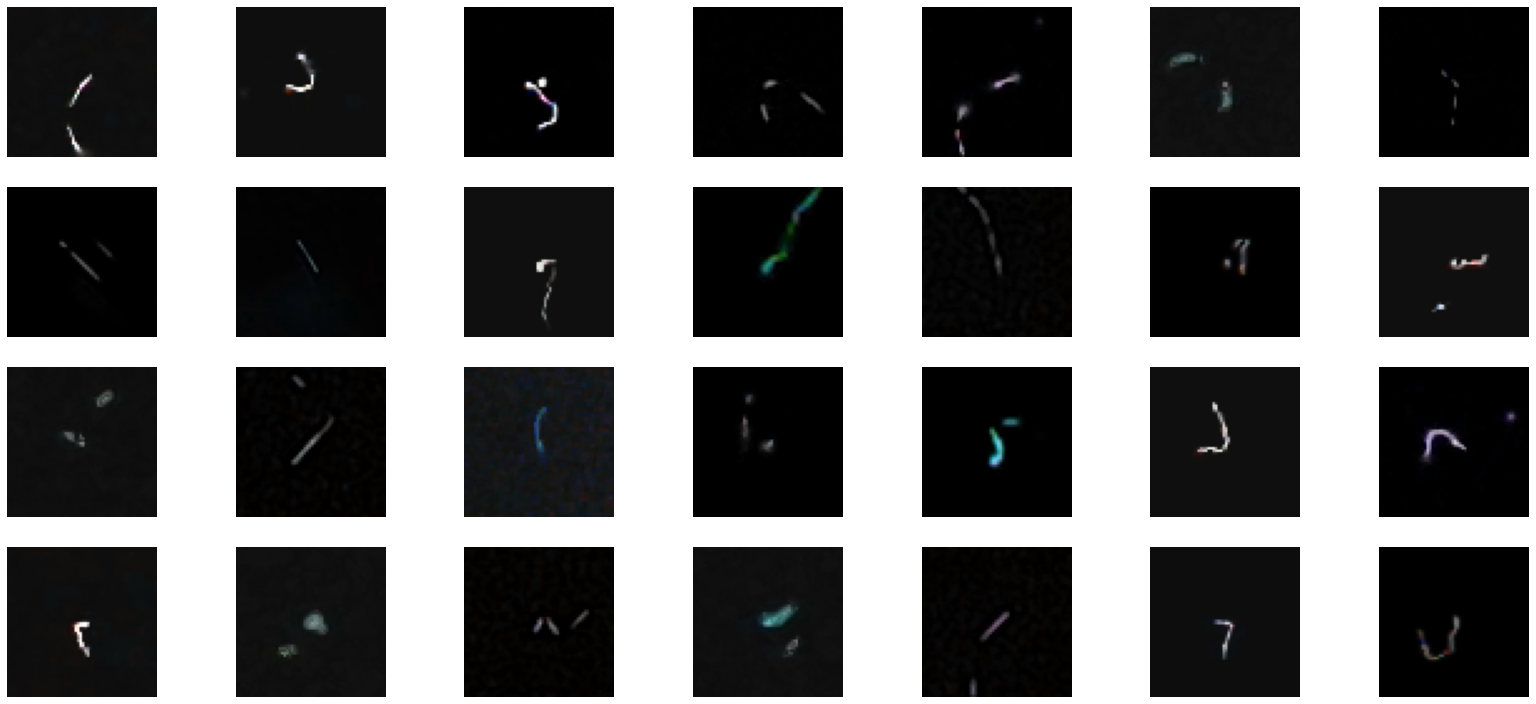

Znalezione: latentDim=24, min_samples=1, eps=412.168164
412.168164: 28
wybrane_final\11665291.png
wybrane_final\11823391.png
wybrane_final\11860397.png
wybrane_final\11860402.png
wybrane_final\11876681.png
wybrane_final\13624927.png
wybrane_final\13831135.png
wybrane_final\13843278.png
wybrane_final\13855513.png
wybrane_final\22031935.png
wybrane_final\22053032.png
wybrane_final\22110706.png
wybrane_final\22111155.png
wybrane_final\22180015.png
wybrane_final\22182800.png
wybrane_final\22203839.png
wybrane_final\22215672.png
wybrane_final\22250688.png
wybrane_final\22323512.png
wybrane_final\22343771.png
wybrane_final\22343774.png
wybrane_final\22425702.png
wybrane_final\22429004.png
wybrane_final\22432354.png
wybrane_final\22442473.png
wybrane_final\22446788.png
wybrane_final\22772316.png
wybrane_final\6162838.png


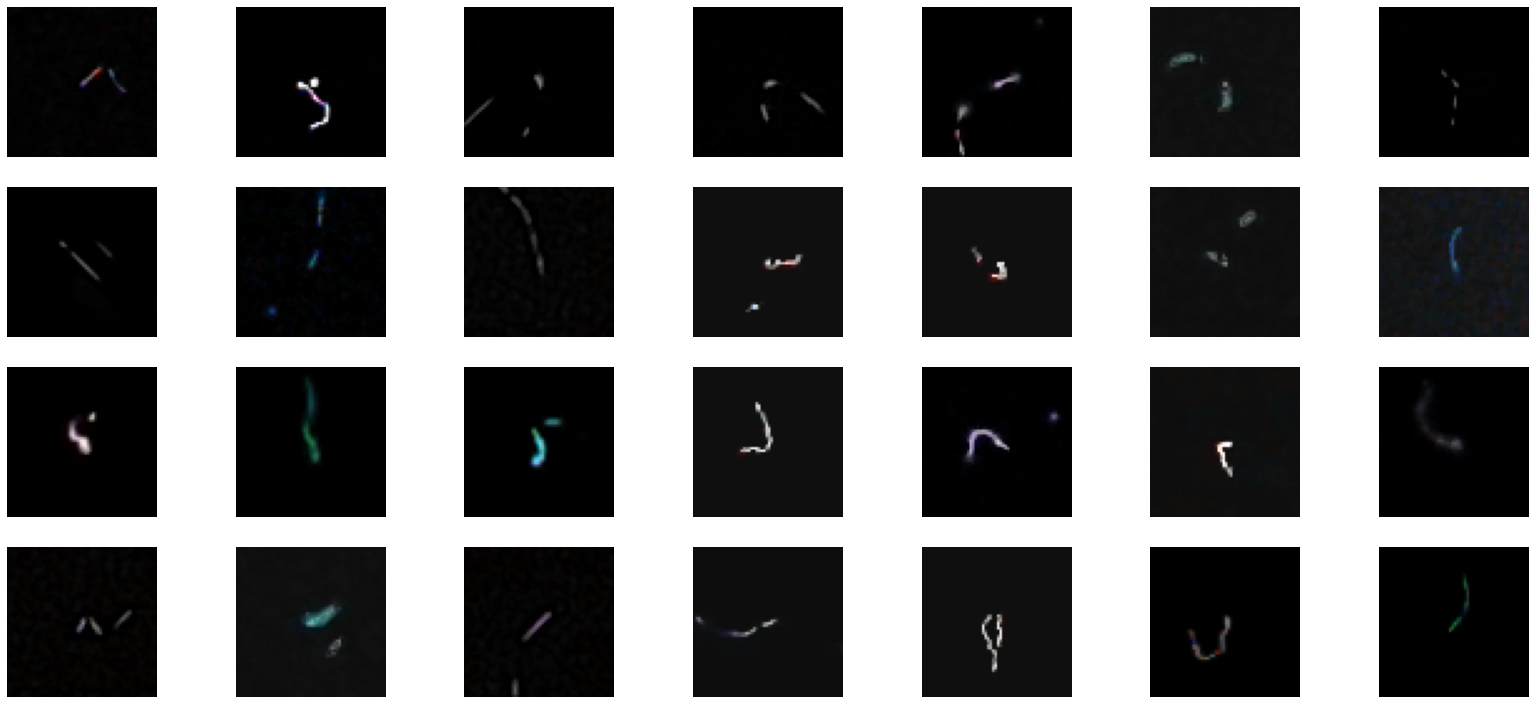

Znalezione: latentDim=32, min_samples=1, eps=424.129858
424.129858: 28
wybrane_final\11823391.png
wybrane_final\11860397.png
wybrane_final\11860402.png
wybrane_final\11876681.png
wybrane_final\13624927.png
wybrane_final\13831135.png
wybrane_final\13843278.png
wybrane_final\16200790.png
wybrane_final\22027241.png
wybrane_final\22031935.png
wybrane_final\22053032.png
wybrane_final\22111155.png
wybrane_final\22177539.png
wybrane_final\22180015.png
wybrane_final\22182800.png
wybrane_final\22204424.png
wybrane_final\22213457.png
wybrane_final\22214072.png
wybrane_final\22215672.png
wybrane_final\22250688.png
wybrane_final\22323512.png
wybrane_final\22343774.png
wybrane_final\22429004.png
wybrane_final\22432354.png
wybrane_final\22446788.png
wybrane_final\22476843.png
wybrane_final\22772316.png
wybrane_final\6162838.png


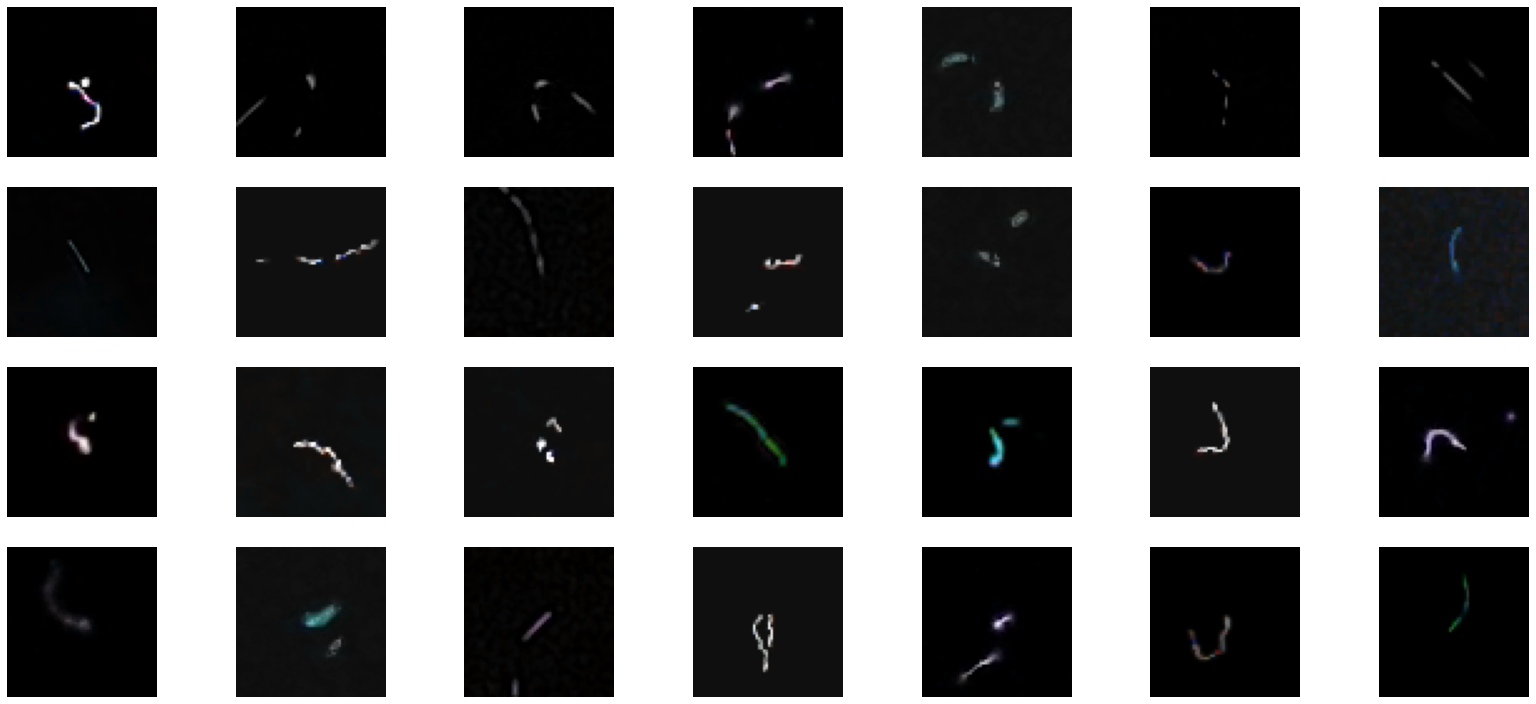

Znalezione: latentDim=48, min_samples=1, eps=421.932812
421.932812: 28
wybrane_final\11636367.png
wybrane_final\11665291.png
wybrane_final\11823391.png
wybrane_final\11860402.png
wybrane_final\11876681.png
wybrane_final\13831135.png
wybrane_final\13836130.png
wybrane_final\13843278.png
wybrane_final\13844465.png
wybrane_final\21859711.png
wybrane_final\22027241.png
wybrane_final\22031737.png
wybrane_final\22031935.png
wybrane_final\22053032.png
wybrane_final\22111155.png
wybrane_final\22114707.png
wybrane_final\22173151.png
wybrane_final\22177539.png
wybrane_final\22180015.png
wybrane_final\22203839.png
wybrane_final\22215672.png
wybrane_final\22250688.png
wybrane_final\22323512.png
wybrane_final\22376080.png
wybrane_final\22429004.png
wybrane_final\22446788.png
wybrane_final\22476843.png
wybrane_final\22772316.png


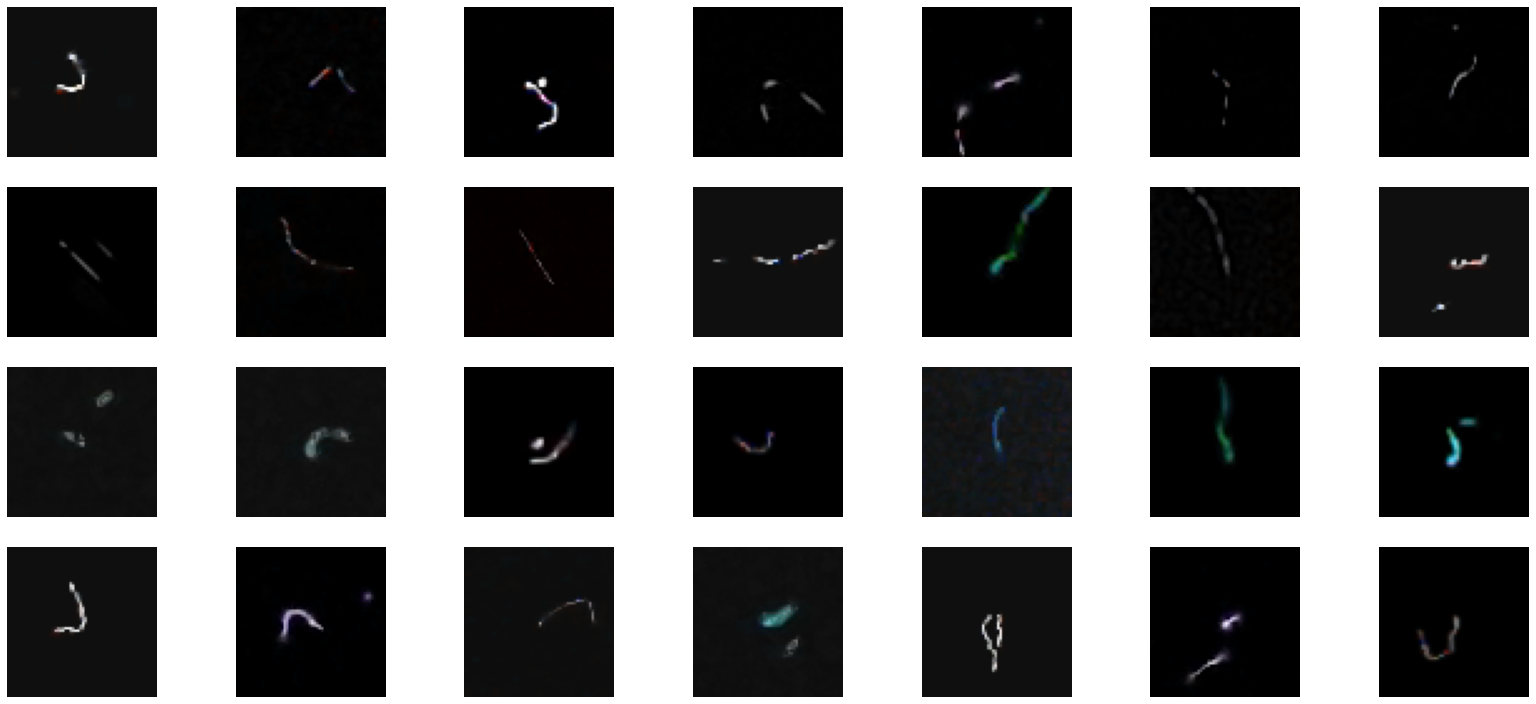

Znalezione: latentDim=64, min_samples=1, eps=448.297363
448.297363: 28
wybrane_final\11636367.png
wybrane_final\11823391.png
wybrane_final\11876681.png
wybrane_final\13831135.png
wybrane_final\13843278.png
wybrane_final\13844465.png
wybrane_final\13855513.png
wybrane_final\22031737.png
wybrane_final\22031935.png
wybrane_final\22038735.png
wybrane_final\22053032.png
wybrane_final\22111155.png
wybrane_final\22114707.png
wybrane_final\22173151.png
wybrane_final\22180015.png
wybrane_final\22204424.png
wybrane_final\22215672.png
wybrane_final\22250688.png
wybrane_final\22304957.png
wybrane_final\22308206.png
wybrane_final\22323512.png
wybrane_final\22353487.png
wybrane_final\22429004.png
wybrane_final\22446788.png
wybrane_final\22515439.png
wybrane_final\22772316.png
wybrane_final\23193894.png
wybrane_final\6162838.png


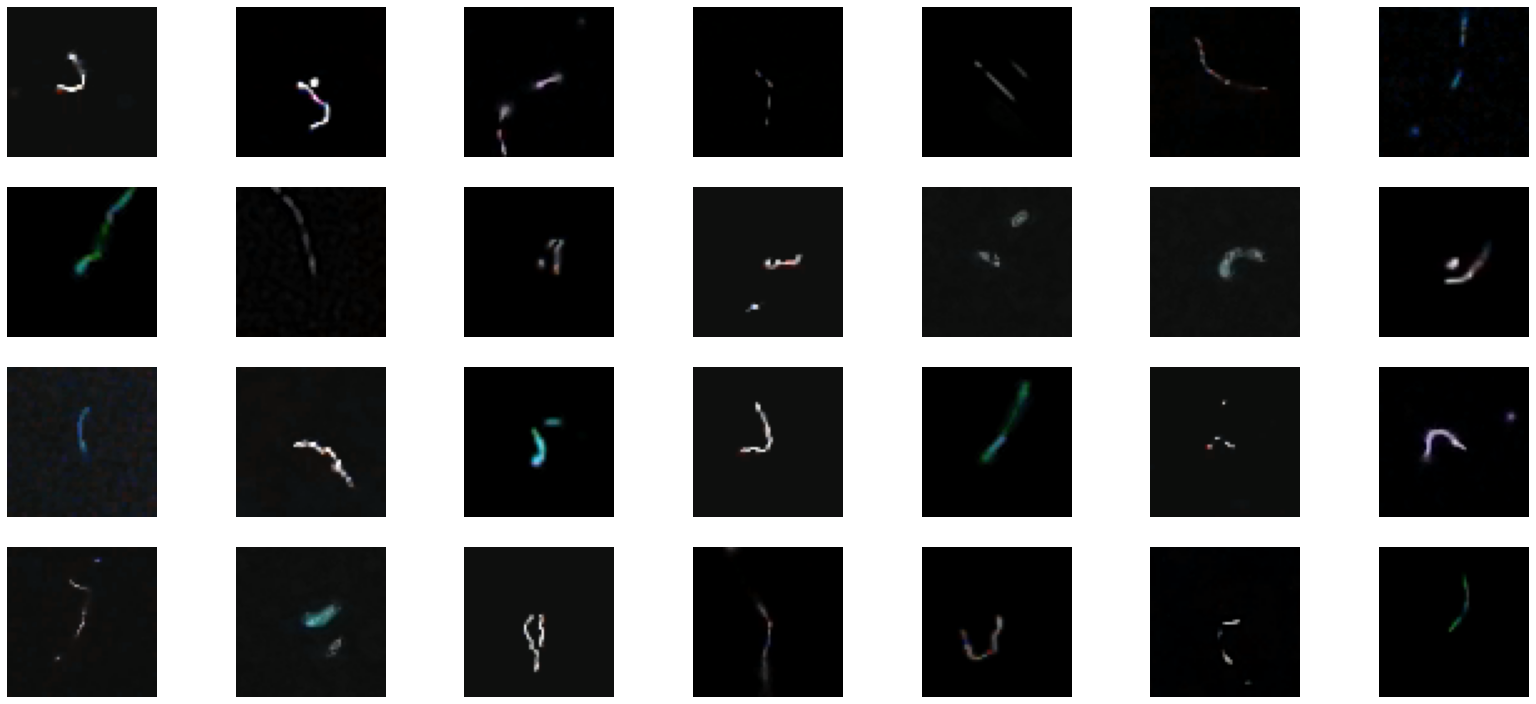

In [11]:
def algomerative(embedding, t_files, latentDim, eps, draw_cluster, ms=1):
    from sklearn.cluster import AgglomerativeClustering
    clustering = AgglomerativeClustering(distance_threshold = eps, n_clusters=None).fit(embedding)


    from collections import Counter
    c=Counter(clustering.labels_)
    values_list = list(c.values())
    keys_list = list(c.keys())

    def find_all_elements(my_list, id):
        ret_list = []
        for ind in range(len(my_list)):
            if my_list[ind] == id:
                ret_list.append(ind)
        return ret_list

    all_cluster_ids = []
    all_ids = find_all_elements(values_list, 1)
    for a in all_ids:
        all_cluster_ids.append(keys_list[a])
    #print(all_ids)
    #print(all_cluster_ids)

    my_ids = []
    for a in range(len(clustering.labels_)):
        if clustering.labels_[a] in all_cluster_ids:
            my_ids.append(a)
    #print(my_ids)

    if draw_cluster:
        print('%f: %d' % (eps, len(my_ids)))
        import matplotlib.pyplot as plt


        fig = plt.figure(figsize=(28, 16))
        columns = 7
        rows = int(len(my_ids) / 7) + 1

        for aaa in range(len(my_ids)):
            img_help = cv2.imread(t_files[my_ids[aaa]])
            print(t_files[my_ids[aaa]])

            aaa1 = aaa + 1
            r = fig.add_subplot(rows, columns, aaa1)
            r.axis("off")
            plt.imshow(img_help)

        plt.show()

        channel = 'all'
        os.makedirs("results_AgglomerativeClustering_%s_%d" % (channel, latentDim), exist_ok=True)
        output_file = "results_AgglomerativeClustering_%s_%d/clusters" % (channel, latentDim)
        output_file_results = "results_AgglomerativeClustering_%s_%d/3sigma.txt" % (channel, latentDim)
        output_file_ok = output_file + ",eps=3sigma.txt"
        with open(output_file_ok, 'w') as fp:
                for element in my_ids:
                    fp.write(str(element) + "\n")
        with open(output_file_results, 'a') as fp:
            fp.write(str(eps) + "\n")
    return len(my_ids)

found_sigmas = np.zeros((len(looking_ld), 1), dtype=np.float64)

for ld in range(0, len(looking_ld)):
    embedding = encoder_embedding(ALL_AC % looking_ld[ld], all_set)
    found_sigmas[ld, 0] = find_sigma(algomerative, embedding, all_files, looking_ld[ld], 1)

#algomerative(all_embedding, all_files, 16, 290, True)
#for i in range(21):
#    algomerative(tnd_embedding, np.hstack([dots_files, tracks_files, worms_files]), 16, eps=(i + 10) * 10, draw_cluster=False)